Knowledge Distillation with Pytorch on MNIST


In [39]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from tqdm import tqdm_notebook
%matplotlib inline

In [40]:
torch.cuda.is_available()

True

There are teacher neural network  and student neural network here. Each network constitutes convolutional neural networks that is composed of 2 layers and one linear layer, whose main goal is to obtain logits. The distinguishing of these networks is that student neura network has less filters(kernels) in each layer unless teacher  neural network. The main goal is to train student network in oeder to get the same predictions as teacher network.

In [41]:
class Teacher(torch.nn.Module): 
  def __init__(self):
    super().__init__()
    self.teacher_net = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels = 1 ,out_channels = 256, kernel_size = 3 ,stride = 2, padding = 1 ,bias = True),
        torch.nn.BatchNorm2d(256),
        torch.nn.LeakyReLU(0.2),
        

        torch.nn.MaxPool2d(kernel_size = 2, stride = 1 , padding =1),

        torch.nn.Conv2d(in_channels = 256 , out_channels = 512 ,kernel_size = 3, stride = 2, padding = 1),
        torch.nn.BatchNorm2d(512)
        
    )

    self.fc = torch.nn.Sequential( 
        torch.nn.Linear(in_features = 512*8*8  , out_features = 300),
        torch.nn.LeakyReLU(0.2),
        torch.nn.Linear(in_features = 300, out_features = 10),
        torch.nn.Dropout(0.2)
    )

  def forward(self,input):
    input = self.teacher_net(input)
    input = input.view(-1, 512*8*8)
    return torch.nn.functional.relu(self.fc(input)) # return [batch, 10] i.e batch of logits for each class

In [42]:
class Student(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.student_net = torch.nn.Sequential(
      torch.nn.Conv2d(in_channels = 1 ,out_channels = 16, kernel_size = 3 ,stride = 2, padding = 1 ,bias = True),
      torch.nn.BatchNorm2d(16),
      torch.nn.LeakyReLU(0.2),

      torch.nn.MaxPool2d(kernel_size = 2, stride = 1 , padding =1),

      torch.nn.Conv2d(in_channels = 16 , out_channels = 32 ,kernel_size = 3, stride = 2, padding = 1),
      torch.nn.BatchNorm2d(32)
    )
    self.fc = torch.nn.Sequential(
        torch.nn.Linear(in_features = 32*8*8 , out_features= 100),
        torch.nn.Linear(in_features = 100 ,out_features = 10),
        torch.nn.Dropout(0.2)

    )

    
  def forward(self,input):
    input = self.student_net(input)
    input = input.view(-1,32*8*8)
    return torch.nn.functional.relu(self.fc(input)) # return [batch,10] i.e batch of logits for each class

In [52]:
class Distiller(torch.nn.Module):
  
  def __init__(self, student, teacher,optimizer,student_loss_fn,distillation_loss_fn,
               alpha,temperature):
    
    super().__init__()
    self.teacher = teacher
    self.student = student
    self.optimizer = optimizer
    self.student_loss_fn = student_loss_fn
    self.distillation_loss_fn = distillation_loss_fn
    self.alpha = alpha
    self.temperature = temperature
  
  
  # one train step 
  def train_step(self, x,y):
    
    self.optimizer.zero_grad()
    teacher_predictions = self.teacher(x).detach()
    # since we don't want train teacher model
    
    # x : torch.Size([batch,1,28,28])
    # y: torch.Size ([batch])
    student_predictions = self.student(x)
    # student_predictions : torch.Size([batch,10])

     

    distillation_loss = self.distillation_loss_fn(torch.nn.Softmax(dim=1)(student_predictions/self.temperature),
                                                  torch.nn.Softmax(dim=1)(teacher_predictions/self.temperature)).sum(1).mean()
    # distillation_loss : torch.Size([])
    
    student_loss = self.student_loss_fn(student_predictions, y.long().cuda()) #  loss of the ground-truth labels

    
    student_loss =  ( 1 - self.alpha )*distillation_loss +  self.alpha*student_loss
    student_loss.backward()
    self.optimizer.step()

    return student_loss.item() 



  def test_step(self, x,y):
    student_predictions = self.student(x).detach()
    student_loss = self.student_loss_fn(student_predictions,y.long().cuda()).detach().cpu().numpy()

    return student_loss


Then, one can prepare the dataset for training of the student network

In [44]:
BATCH_SIZE = 100
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),torchvision.transforms.Normalize(mean = 0.5, std = 0.5)])
train_data = torchvision.datasets.MNIST(root='./data',train=True,     transform=transform,  download=True)
test_data =  torchvision.datasets.MNIST(root='./data' ,train =False, transform=transform ,download =True)
train_loader = torch.utils.data.DataLoader(dataset=train_data,batch_size=BATCH_SIZE,shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data,batch_size=BATCH_SIZE,shuffle = False)

The following code is aimed to train teacher. Since , we are inclined to believe that teacher is fixed while stident is training .So, let's train the teacher



In [45]:
teacher = Teacher().cuda()
optimizer_teacher = torch.optim.Adam(teacher.parameters(),lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()

In [46]:
def train_epoch(model,optimizer,train_loader):

  losses = list()
  model.train()

  for data,label in tqdm_notebook(train_loader):
    data,label = torch.autograd.Variable(data),torch.autograd.Variable(label)
    optimizer.zero_grad()
    data,label = data.cuda(),label.cuda()

    loss = criterion( model(data) , label)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
  return losses


In [47]:
def test_model(model,test_loader):

  model.eval()
  total_loss = 0

  with torch.no_grad():
    for data,label in test_loader:
      data,label = torch.autograd.Variable(data),torch.autograd.Variable(label)
      data,label = data.cuda(),label.cuda()

      #indices_of_max = torch.max(probs,dim=1)[1]
      loss = criterion( model(data),label)
      total_loss += loss.item()*data.shape[0]
    avg_loss = total_loss/(len(test_loader.dataset))
  return avg_loss

In [48]:
def train_test_model(model, train_loader,test_loader,optimizer, num_epochs):
  train_loss = list()
  test_loss = list()

  for epoch in tqdm_notebook(range(num_epochs)):

    train_loss.extend( train_epoch(model,optimizer,train_loader) )
    test_loss.append( test_model(model,test_loader) )
  
  return train_loss , test_loss

In [49]:
train_loss,test_loss = train_test_model(teacher,train_loader,test_loader,optimizer_teacher,5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


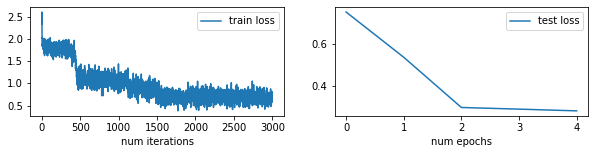

In [50]:
fig,ax = plt.subplots(1,2,figsize=(10,2))
ax = ax.flatten()
ax[0].plot(train_loss,label = 'train loss')
ax[1].plot(test_loss, label = 'test loss')
ax[0].legend()
ax[0].set_xlabel("num iterations")
ax[1].set_xlabel("num epochs")
ax[1].legend()
plt.show()

As soon as we trained the teacher model, one can move on to distillation.

In [53]:
student = Student().cuda()

In [54]:
distiller = Distiller(student, teacher, optimizer=torch.optim.Adam(student.parameters(),lr=1e-3),
                 student_loss_fn = torch.nn.CrossEntropyLoss(),distillation_loss_fn = torch.nn.KLDivLoss(reduction='none'),
                 alpha = 0.1,temperature = 10)

Train student model via the teacher model

In [55]:
def train_student(num_epochs,distiller,train_loader):
  losses_of_student_train = list()
  losses_of_student_test =  list()

  for epoch in tqdm_notebook(range(num_epochs)):
    distiller.student.train()
     
    for data,label in train_loader:
      data  = torch.autograd.Variable(data)
      label = torch.autograd.Variable(label)
      data = data.cuda()
      label = label.cuda()
      loss_of_step = distiller.train_step(data,label)
      losses_of_student_train.append(loss_of_step)

    total_test = 0
    with torch.no_grad():
      for data,label in test_loader:
        data = torch.autograd.Variable(data)
        label = torch.autograd.Variable(label)
        data = data.cuda()
        label = label.cuda()
        total_test += np.sum(distiller.test_step(data,label))
      avg_loss = total_test/ (len(test_loader))
    losses_of_student_test.append(avg_loss)
  

  return losses_of_student_train, losses_of_student_test




In [56]:
losses_of_student_train, losses_of_student_test = train_student(5,distiller,train_loader)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


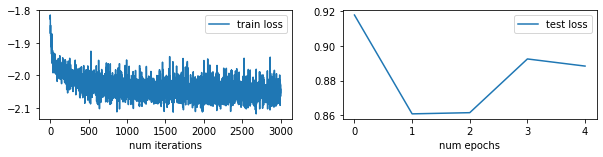

In [57]:
fig,ax = plt.subplots(1,2,figsize=(10,2))
ax = ax.flatten()
ax[0].plot(losses_of_student_train,label = 'train loss')
ax[1].plot(losses_of_student_test, label = 'test loss')
ax[0].legend()
ax[0].set_xlabel("num iterations")
ax[1].set_xlabel("num epochs")
ax[1].legend()
plt.show()

https://keras.io/examples/vision/knowledge_distillation/